# Практическое задание № 3. Вариант 3.
### Решается задача интерполяции функции из $\mathbb{L_2[1, 2]}$

In [179]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

Вспомогательные функции

In [180]:
def basis_funcs():
    return [
        lambda x: 1,
        lambda x: np.log(x),
        lambda x: x ** (-2),
        lambda x: x ** (-1),
        lambda x: x,
        lambda x: x ** 2,
        lambda x: x ** 3
    ]


def func_from_coefs(coefs):
    basis = [
        lambda x: 1,
        lambda x: x,
        lambda x: np.sqrt(x),
        lambda x: x ** 2,
        lambda x: x ** 3,
        lambda x: x ** 4,
        lambda x: x ** 6
    ]
    def f(x):
        return sum(c * b(x) for c, b in zip(coefs, basis))
    return f


def func_from_basis(c):
    basis = basis_funcs()
    def f(x):
        return sum(c * b(x) for c, b in zip(c, basis))
    return f

Скалярное произведение в $\mathbb{L_2[1, 2]}$

In [181]:
a, b = 1, 2

def scalar_product(f, g):
    return quad(lambda x: f(x) * g(x), a, b)[0]

Разложение Фурье

In [182]:
def l2_approximate(input_coefs, verbose=False):
    f = func_from_coefs(input_coefs)
    basis = basis_funcs()
    S = np.zeros((len(basis), len(basis)))
    
    for i in range(len(basis)):
        for j in range(len(basis)):
            S[i, j] = scalar_product(basis[i], basis[j])

    b_vec = np.zeros(len(basis))
    for i in range(len(basis)):
        b_vec[i] = scalar_product(f, basis[i])


    c = np.linalg.solve(S, b_vec)
    if verbose:
        print("Матрица S:\n", S)
        print("Вектор b:\n", b_vec)
        print("Коэффициенты аппроксимации:\n", c)
    return c

Ортогонализация Грамма-Шмидта

In [183]:
def gram_shmidt(basis):
    ortho_basis = []
    for i in range(len(basis)):
        def make_orth(i):
            def ortho_func(x):
                value = basis[i](x)
                for j in range(i):
                    value -= scalar_product(basis[i], ortho_basis[j]) / scalar_product(ortho_basis[j], ortho_basis[j]) * ortho_basis[j](x)
                return value
            return ortho_func
        ortho_basis.append(make_orth(i))
    return ortho_basis



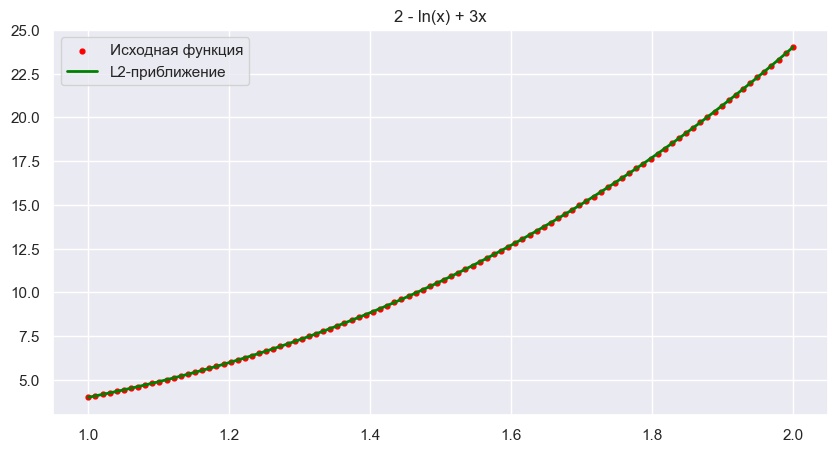

L2-норма ошибки: 9.39400e-09


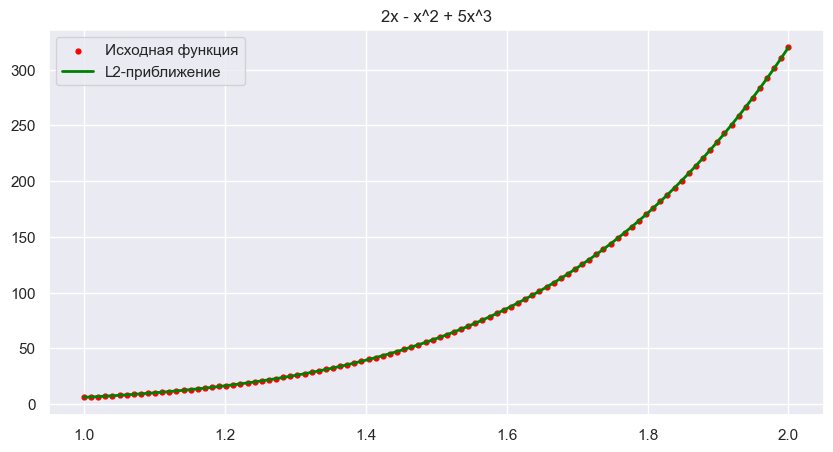

L2-норма ошибки: 6.86870e-02


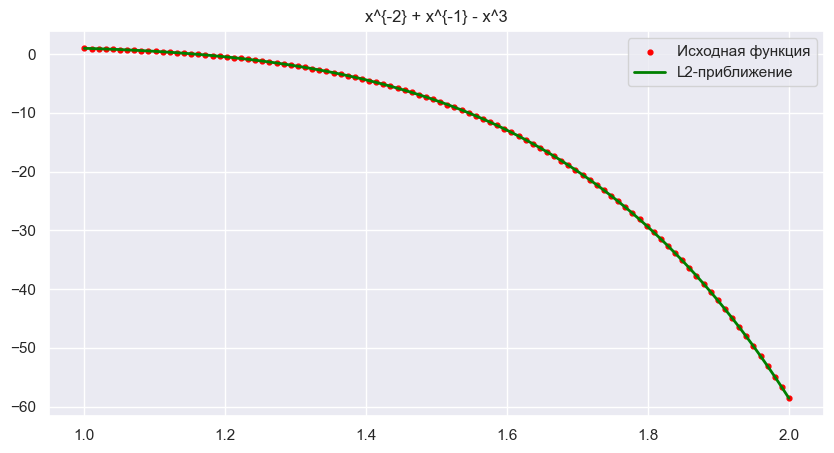

L2-норма ошибки: 1.37676e-02


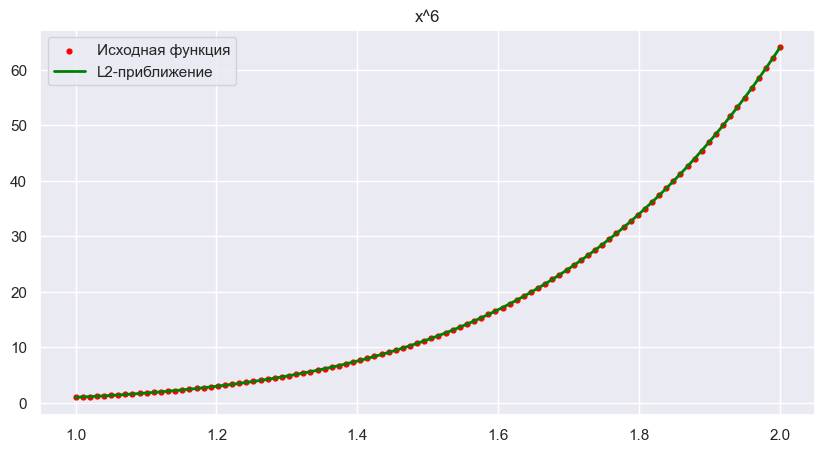

L2-норма ошибки: 1.37676e-02


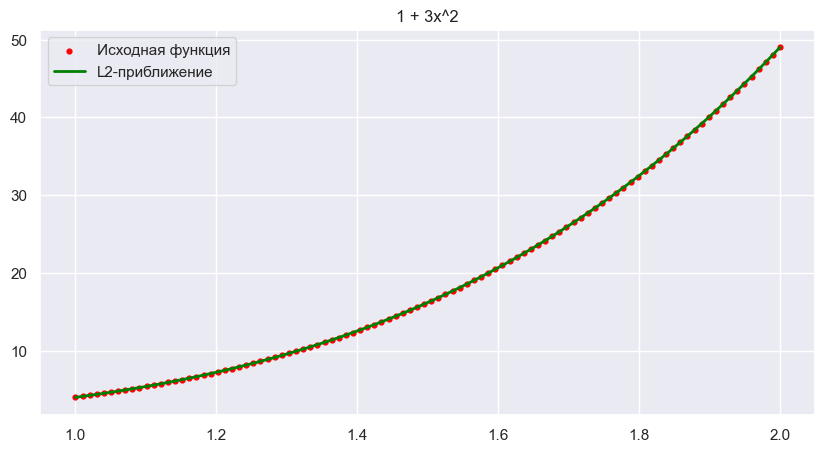

L2-норма ошибки: 4.53595e-04


In [184]:
x = np.linspace(a, b, 100)

function_examples = [
    [2, -1, 0, 0, 3, 0, 0],    # 2 - ln(x) + 3x
    [0, 0, 0, 0, 2, -1, 5],    # 2x - x^2 + 5x^3
    [0, 0, 1, 1, 0, 0, -1],    # x^{-2} + x^{-1} - x^3
    [0, 0, 0, 0, 0, 0, 1],     # x^6
    [1, 0, 0, 0, 0, 3, 0],     # 1 + 3x^2
]

titles = [
    '2 - ln(x) + 3x',
    '2x - x^2 + 5x^3',
    'x^{-2} + x^{-1} - x^3',
    'x^6',
    '1 + 3x^2',
]

with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    err_orth.clear()
    err_no_orth.clear()
    for idx, f_coefs in enumerate(function_examples):
        f = func_from_coefs(f_coefs)

        appr_coefs = l2_approximate(f_coefs)
        appr_f = func_from_basis(appr_coefs)

        plt.figure(figsize=(10, 5))
        plt.scatter(x, f(x), label="Исходная функция", color="r", s=12)
        plt.plot(x, appr_f(x), label="L2-приближение", color="green", linewidth=2)
        plt.title(titles[idx])
        plt.legend()
        plt.show()

        print(f'L2-норма ошибки: {np.linalg.norm(f(x) - appr_f(x))/(b-a):.5e}')

Алгоритм Ремеза

In [185]:
def remez_approximate(input_coefs, n_iter=5, grid_points=100):
    f_true = func_from_coefs(input_coefs)
    basis = basis_funcs()
    x_grid = np.linspace(a, b, grid_points)

    x_ext = np.linspace(a, b, len(basis) + 1)
    for k in range(n_iter):

        A = np.zeros((len(basis) + 1, len(basis) + 1))
        for i in range(len(basis) + 1):
            for j in range(len(basis)):
                A[i, j] = basis[j](x_ext[i])
            A[i, -1] = (-1)**i
        y = np.array([f_true(xe) for xe in x_ext])
        sol = np.linalg.lstsq(A, y, rcond=None)[0]
        c, error = sol[:-1], sol[-1]
        approx = func_from_basis(c)
        errors = f_true(x_grid) - approx(x_grid)
        idxs = np.argpartition(np.abs(errors), -len(basis) - 1)[-len(basis) - 1 :]
        x_ext = np.sort(x_grid[idxs])
        x_ext[0] = a
        x_ext[-1] = b
    return c

Сравним два метода

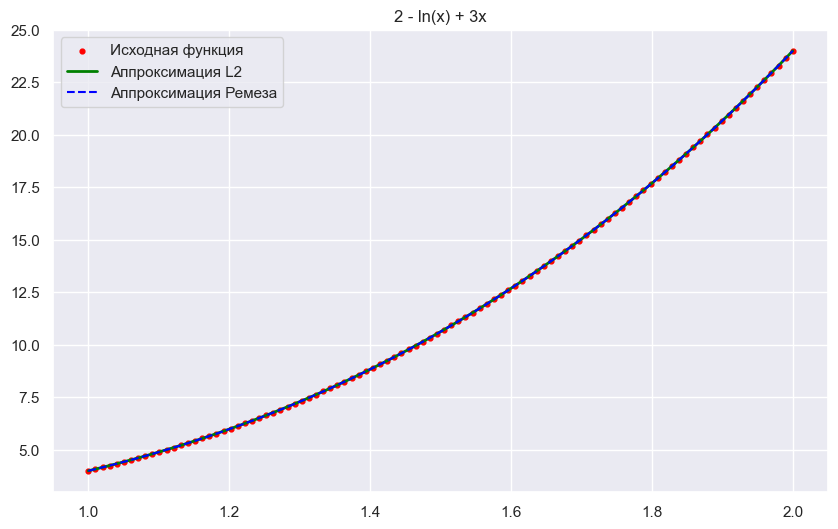

L2-норма ошибки (L2): 9.39400e-09
L2-норма ошибки (Ремез): 3.43801e-09
C-норма ошибки (L2): 4.13373e-09
C-норма ошибки (Ремез): 6.68660e-10


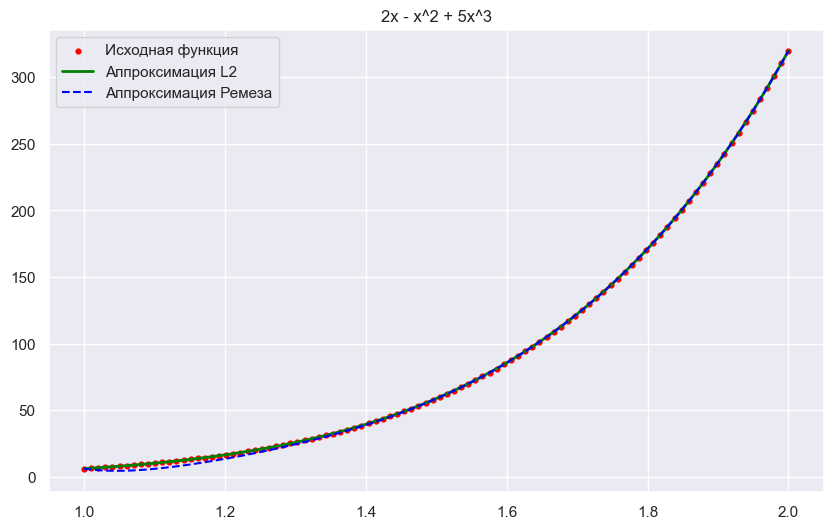

L2-норма ошибки (L2): 6.86870e-02
L2-норма ошибки (Ремез): 1.73596e+01
C-норма ошибки (L2): 2.55189e-02
C-норма ошибки (Ремез): 4.23663e+00


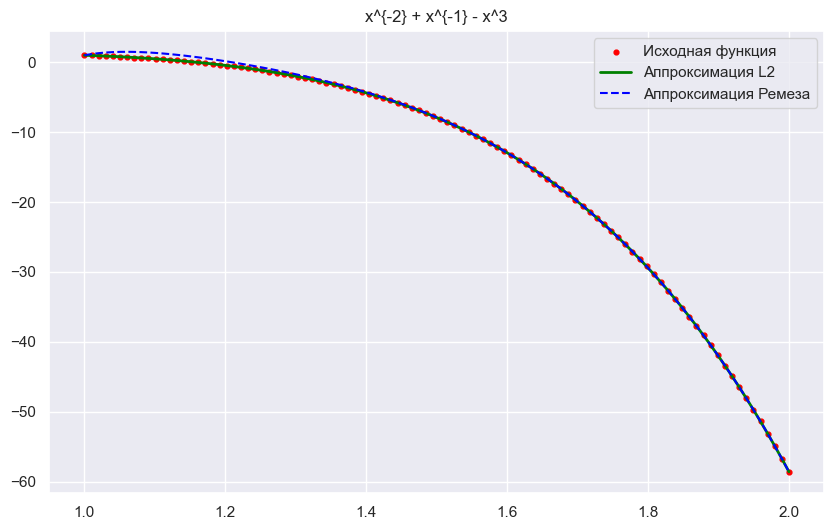

L2-норма ошибки (L2): 1.37676e-02
L2-норма ошибки (Ремез): 3.47787e+00
C-норма ошибки (L2): 5.11555e-03
C-норма ошибки (Ремез): 8.48786e-01


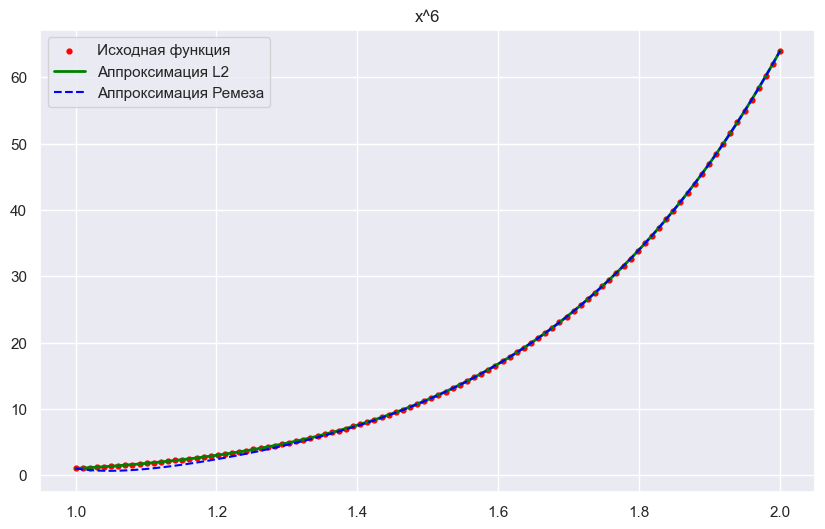

L2-норма ошибки (L2): 1.37676e-02
L2-норма ошибки (Ремез): 3.47786e+00
C-норма ошибки (L2): 5.11559e-03
C-норма ошибки (Ремез): 8.48785e-01


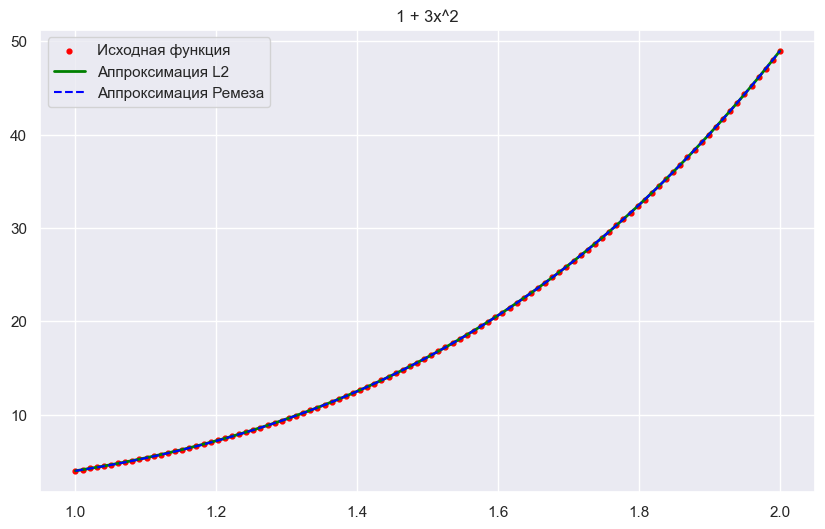

L2-норма ошибки (L2): 4.53595e-04
L2-норма ошибки (Ремез): 8.91580e-02
C-норма ошибки (L2): 1.76890e-04
C-норма ошибки (Ремез): 2.18766e-02


In [186]:
def plot_and_compare(input_coefs, title=''):
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        f = func_from_coefs(input_coefs)
        
        appr_coefs_l2 = l2_approximate(input_coefs)
        f_l2 = func_from_basis(appr_coefs_l2)
        
        appr_coefs_rem = remez_approximate(input_coefs)
        f_rem = func_from_basis(appr_coefs_rem)
        
        y = f(x)
        y_l2 = f_l2(x)
        y_rem = f_rem(x)
        
        plt.figure(figsize=(10,6))
        plt.scatter(x, y, label="Исходная функция", s=12, color='r')
        plt.plot(x, y_l2, label="Аппроксимация L2", color='green', linewidth=2)
        plt.plot(x, y_rem, '--', label="Аппроксимация Ремеза", color='blue')
        plt.title(title)
        plt.legend()
        plt.show()
        
        print(f'L2-норма ошибки (L2): {np.linalg.norm(y - y_l2)/(b-a):.5e}')
        print(f'L2-норма ошибки (Ремез): {np.linalg.norm(y - y_rem)/(b-a):.5e}')
        print(f'C-норма ошибки (L2): {np.max(np.abs(y - y_l2)):.5e}')
        print(f'C-норма ошибки (Ремез): {np.max(np.abs(y - y_rem)):.5e}')


for ex, t in zip(examples, titles):
    plot_and_compare(ex, t)
